In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
# https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib

In [2]:

df_train = pd.read_excel(r"E:\Nikhil\Skillenza\Level 2\train.xlsx" , header = 0)
df_test =pd.read_excel(r"E:\Nikhil\Skillenza\Level 2\test.xlsx" , header = 0) 

In [3]:
df_train.head()

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status
0,1,188,Feed,clay,1,0,0.0,0,1,0
1,2,209,Feed,clay,1,0,0.0,0,2,1
2,3,257,Feed,clay,1,0,0.0,0,2,1
3,4,257,Feed,silt,1,0,0.0,0,2,1
4,5,342,Feed,clay,1,0,0.0,0,2,1


In [4]:
df_train["Crop"].replace({"Feed":0 ,"Food":1 } , inplace = True)
df_test["Crop"].replace({"Feed":0 ,"Food":1 } , inplace = True)

df_train["Soil"].replace({"clay":0 ,"silt":1 } , inplace = True)
df_test["Soil"].replace({"clay":0 ,"silt":1 } , inplace = True)

In [5]:
df_train.Soil.value_counts()

0    43556
1    36444
Name: Soil, dtype: int64

In [6]:
df_train.shape

(80000, 10)

In [7]:
df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Crop_status'] = 0
print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(80000, 11) (35000, 11)
(115000, 11)


In [8]:
df_train.head()

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status,train_flag
0,1,188,0,0,1,0,0.0,0,1,0,1
1,2,209,0,0,1,0,0.0,0,2,1,1
2,3,257,0,0,1,0,0.0,0,2,1,1
3,4,257,0,1,1,0,0.0,0,2,1,1
4,5,342,0,0,1,0,0.0,0,2,1,1


In [9]:
df_test.head()

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,train_flag,Crop_status
0,1,188,0,1,1,0,NaN,0,2,0,0
1,2,410,0,1,1,0,0.0,0,2,0,0
2,3,626,0,0,1,0,0.0,0,2,0,0
3,4,731,0,0,1,0,0.0,0,2,0,0
4,5,789,1,0,1,0,0.0,0,1,0,0


In [10]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_status')
feature_cols.remove('train_flag')
label_col = 'Crop_status'
print(feature_cols)




['Insects', 'Crop', 'Soil', 'Category_of_Toxicant', 'Does_count', 'Number_of_Weeks_Used', 'Number_Weeks_does_not used', 'Season']


In [11]:
feature_cols

['Insects',
 'Crop',
 'Soil',
 'Category_of_Toxicant',
 'Does_count',
 'Number_of_Weeks_Used',
 'Number_Weeks_does_not used',
 'Season']

In [12]:
df_data

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status,train_flag
0,1,188,0,0,1,0,0.0,0,1,0,1
1,2,209,0,0,1,0,0.0,0,2,1,1
2,3,257,0,0,1,0,0.0,0,2,1,1
3,4,257,0,1,1,0,0.0,0,2,1,1
4,5,342,0,0,1,0,0.0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,677,1,1,2,40,27.0,3,1,0,0
34996,34997,731,1,1,2,10,8.0,20,3,0,0
34997,34998,732,1,1,2,10,10.0,20,2,0,0
34998,34999,731,1,1,2,10,31.0,2,2,0,0


In [13]:
df_data = df_data.reset_index(drop=True)
len(df_data)
df_data

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status,train_flag
0,1,188,0,0,1,0,0.0,0,1,0,1
1,2,209,0,0,1,0,0.0,0,2,1,1
2,3,257,0,0,1,0,0.0,0,2,1,1
3,4,257,0,1,1,0,0.0,0,2,1,1
4,5,342,0,0,1,0,0.0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
114995,34996,677,1,1,2,40,27.0,3,1,0,0
114996,34997,731,1,1,2,10,8.0,20,3,0,0
114997,34998,732,1,1,2,10,10.0,20,2,0,0
114998,34999,731,1,1,2,10,31.0,2,2,0,0


In [14]:
df_data

,ID,Insects,Crop,Soil,Category_of_Toxicant,Does_count,Number_of_Weeks_Used,Number_Weeks_does_not used,Season,Crop_status,train_flag
0,1,188,0,0,1,0,0.0,0,1,0,1
1,2,209,0,0,1,0,0.0,0,2,1,1
2,3,257,0,0,1,0,0.0,0,2,1,1
3,4,257,0,1,1,0,0.0,0,2,1,1
4,5,342,0,0,1,0,0.0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
114995,34996,677,1,1,2,40,27.0,3,1,0,0
114996,34997,731,1,1,2,10,8.0,20,3,0,0
114997,34998,732,1,1,2,10,10.0,20,2,0,0
114998,34999,731,1,1,2,10,31.0,2,2,0,0


In [15]:
df_data['Soil_Type_Damage'] = df_data.sort_values(['ID']).groupby(['Soil'])['Crop_status'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage'] = df_data.sort_values(['ID']).groupby(['Insects'])['Crop_status'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Crop_Type_Damage'] = df_data.sort_values(['ID']).groupby(['Crop'])['Crop_status'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Pesticide_Use_Category_Damage'] = df_data.sort_values(['ID']).groupby(['Category_of_Toxicant'])['Crop_status'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


df_data['Season_Damage'] = df_data.sort_values(['ID']).groupby(['Season'])['Crop_status'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values


#df_data['Soil_Type_Damage_lag2'] = df_data.sort_values(['ID']).groupby(['Soil'])['Crop_status'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage_lag2'] = df_data.sort_values(['ID']).groupby(['Insects'])['Crop_status'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

#df_data['Crop_Type_Damage_lag2'] = df_data.sort_values(['ID']).groupby(['Crop'])['Crop_status'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

#df_data['Pesticide_Use_Category_Damage_lag2'] = df_data.sort_values(['ID']).groupby(['Category_of_Toxicant'])['Crop_status'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage_lag2'] = df_data.sort_values(['ID']).groupby(['Season'])['Crop_status'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values



In [16]:
df_data.loc[df_data['train_flag'] == 0, 'Crop_status'] = -999

In [17]:
df_data['Crop_Damage_lag1'] = df_data['Crop_status'].shift(fill_value=-999)
df_data['Estimated_Insects_Count_lag1'] = df_data['Insects'].shift(fill_value=-999)
#df_data['Crop_Type_lag1'] = df_data['Crop'].shift(fill_value=-999)
df_data['Soil_Type_lag1'] = df_data['Soil'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag1'] = df_data['Category_of_Toxicant'].shift(fill_value=-999)
df_data['Number_Doses_Week_lag1'] = df_data['Does_count'].shift(fill_value=-999)
df_data['Number_Weeks_Used_lag1'] = df_data['Number_of_Weeks_Used'].shift(fill_value=-999)
df_data['Number_Weeks_Quit_lag1'] = df_data['Number_Weeks_does_not used'].shift(fill_value=-999)
df_data['Season_lag1'] = df_data['Season'].shift(fill_value=-999)

df_data['Crop_Damage_lag2'] = df_data['Crop_status'].shift(periods=2,fill_value=-999)
df_data['Estimated_Insects_Count_lag2'] = df_data['Insects'].shift(periods=2,fill_value=-999)
#df_data['Crop_Type_lag2'] = df_data['Crop'].shift(fill_value=-999)
#df_data['Soil_Type_lag2'] = df_data['Soil'].shift(fill_value=-999)
#df_data['Pesticide_Use_Category_lag2'] = df_data['Category_of_Toxicant'].shift(periods=2,fill_value=-999)
df_data['Number_Doses_Week_lag2'] = df_data['Does_count'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Used_lag2'] = df_data['Number_of_Weeks_Used'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Quit_lag2'] = df_data['Number_Weeks_does_not used'].shift(periods=2,fill_value=-999)
df_data['Season_lag2'] = df_data['Season'].shift(periods=2,fill_value=-999)

In [18]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]
print(df_train.train_flag.value_counts())
print(df_test.shape)

1    80000
Name: train_flag, dtype: int64
(35000, 32)


In [19]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

C:\Users\lenovo\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
print(df_train.shape, df_test.shape)

(80000, 31) (35000, 30)


In [21]:
del df_data

In [22]:
df_train.columns

Index(['ID', 'Insects', 'Crop', 'Soil', 'Category_of_Toxicant', 'Does_count',
       'Number_of_Weeks_Used', 'Number_Weeks_does_not used', 'Season',
       'Crop_status', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage',
       'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage',
       'Estimated_Insects_Count_Damage_lag2', 'Season_Damage_lag2',
       'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Soil_Type_lag1',
       'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1',
       'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1',
       'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2',
       'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2',
       'Number_Weeks_Quit_lag2', 'Season_lag2'],
      dtype='object')

In [23]:
missing_impute = -999

In [24]:
df_train['Number_of_Weeks_Used'] = df_train['Number_of_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_of_Weeks_Used'] = df_test['Number_of_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag1'] = df_train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag1'] = df_test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag2'] = df_train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag2'] = df_test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

<ipython-input-24-50fa5178d8fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Number_of_Weeks_Used'] = df_train['Number_of_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
<ipython-input-24-50fa5178d8fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Number_of_Weeks_Used'] = df_test['Number_of_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
<ipython-input-24-50fa5178d8fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [25]:
df_train, df_eval = train_test_split(df_train, test_size=0.20, shuffle=True, stratify=df_train[label_col])

In [26]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_status')
label_col = 'Crop_status'
print(feature_cols)

['Insects', 'Crop', 'Soil', 'Category_of_Toxicant', 'Does_count', 'Number_of_Weeks_Used', 'Number_Weeks_does_not used', 'Season', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage', 'Estimated_Insects_Count_Damage_lag2', 'Season_Damage_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2', 'Season_lag2']


In [27]:
df_train.Soil.value_counts()

0    34849
1    29151
Name: Soil, dtype: int64

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 69900 to 39837
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   64000 non-null  int64  
 1   Insects                              64000 non-null  int64  
 2   Crop                                 64000 non-null  int64  
 3   Soil                                 64000 non-null  int64  
 4   Category_of_Toxicant                 64000 non-null  int64  
 5   Does_count                           64000 non-null  int64  
 6   Number_of_Weeks_Used                 64000 non-null  float64
 7   Number_Weeks_does_not used           64000 non-null  int64  
 8   Season                               64000 non-null  int64  
 9   Crop_status                          64000 non-null  int64  
 10  Soil_Type_Damage                     64000 non-null  float64
 11  Estimated_Insects_Count_

In [29]:
cat_cols = ['Crop', 'Soil', 'Category_of_Toxicant', 'Season', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']


#cat_cols = ['Crop', 'Soil', 'Category_of_Toxicant', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

In [30]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [31]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), 
                                                                                          (df_eval[feature_cols], df_eval[label_col])],
        eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Category_of_Toxicant', 'Crop', 'Pesticide_Use_Category_lag1', 'Season', 'Season_lag1', 'Soil', 'Soil_Type_lag1']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
C:\Users\lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	valid_0's multi_error: 0.166047	valid_0's multi_logloss: 0.503249	valid_1's multi_error: 0.166063	valid_1's multi_logloss: 0.50382
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.166047	valid_0's multi_logloss: 0.481146	valid_1's multi_error: 0.166063	valid_1's multi_logloss: 0.482046
[3]	valid_0's multi_error: 0.166047	valid_0's multi_logloss: 0.462791	valid_1's multi_error: 0.166063	valid_1's multi_logloss: 0.464184
[4]	valid_0's multi_error: 0.166047	valid_0's multi_logloss: 0.448191	valid_1's multi_error: 0.166063	valid_1's multi_logloss: 0.449878
[5]	valid_0's multi_error: 0.166047	valid_0's multi_logloss: 0.433536	valid_1's multi_error: 0.166063	valid_1's multi_logloss: 0.435258
[6]	valid_0's multi_error: 0.166047	valid_0's multi_logloss: 0.418601	valid_1's multi_error: 0.166063	valid_1's multi_logloss: 0.420608
[7]	valid_0's multi_error: 0.166047	valid_0's multi_logloss: 0.407244	valid_1's multi_error: 0.166063	valid_1's multi_loglo

In [32]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 847, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [33]:
df_train = pd.concat((df_train, df_eval))

In [34]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

# eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
ACC: 0.964375


In [35]:
#ACC: 0.9680357142857143

# ACC: 0.971546875 rs57


#0.9885694444444444 orignal  0.9596125  0.9609125




#ACC: 0.967025 drop two feature soil leg2 crop le2 0.9677625


In [36]:
df_test.columns

Index(['ID', 'Insects', 'Crop', 'Soil', 'Category_of_Toxicant', 'Does_count',
       'Number_of_Weeks_Used', 'Number_Weeks_does_not used', 'Season',
       'Soil_Type_Damage', 'Estimated_Insects_Count_Damage',
       'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage',
       'Estimated_Insects_Count_Damage_lag2', 'Season_Damage_lag2',
       'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Soil_Type_lag1',
       'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1',
       'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1',
       'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2',
       'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2',
       'Number_Weeks_Quit_lag2', 'Season_lag2'],
      dtype='object')

In [37]:
preds = clf.predict(df_test[feature_cols])

In [38]:
Counter(df_train['Crop_status'])

Counter({1: 11183, 0: 66716, 2: 2101})

In [39]:
Counter(preds)

Counter({0: 31750, 1: 3202, 2: 48})

In [40]:
# submission = pd.DataFrame({'ID':df_test['ID'], 'Crop_Damage':preds})
# submission 



l3p1_submission1 = pd.DataFrame({"ID":df_test["ID"],
                               "Crop_status":preds})

In [42]:
l3p1_submission1.to_csv(r"E:/Nikhil/Skillenza/Level 2/sub5",index=False)

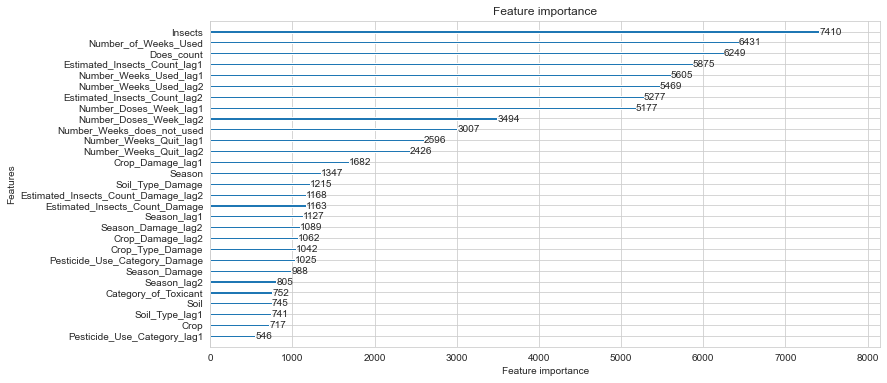

In [43]:
plt.rcParams['figure.figsize'] = (12, 6)
lgb.plot_importance(clf)
plt.show()